<a href="https://colab.research.google.com/github/pen1064/Toronto_House_Market/blob/main/Data_Exploration_And_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
house_data = pd.read_excel("house_detail_clean1.xlsx")
house_data.head(3)

,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code,Line,Station,Dist,final_price_persqft
0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,3,2,849.5,1,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76,Yonge-University-Spadina,College,0.224219,1006.474397
1,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1,1,549.5,0,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104,Yonge-University-Spadina,Eglinton,0.407749,1000.909918
2,"514 - 65 East Liberty St, Toronto (C4515763) |...",665000,600000,2,1,649.5,1,Rare Loft-Like Condo In Liberty Village W/ 18'...,C4515763,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82,Yonge-University-Spadina,St. Andrew,2.597742,1023.864511


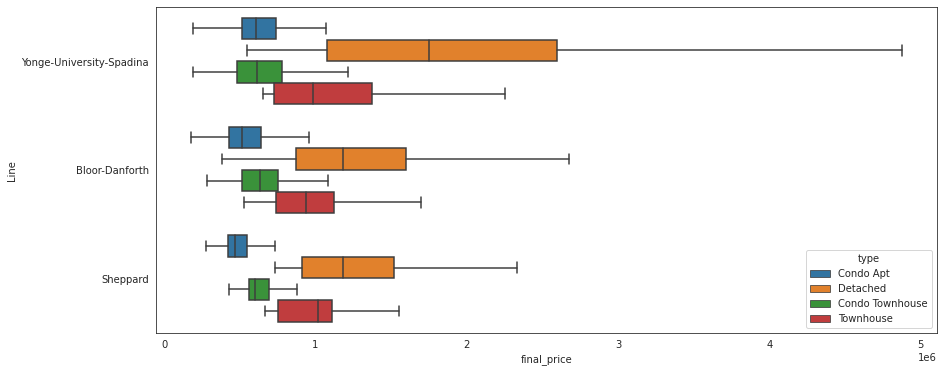

In [40]:
median = []
tar_type = ["Condo Apt", "Condo Townhouse", "Detached", "Townhouse"]
kpi = "final_price"
house_dataf = house_data[house_data.type.isin(tar_type)]
fig, ax = plt.subplots(figsize = [14,6])
bx = sns.boxplot(y = "Line", x=kpi, data = house_dataf, hue = "type", showfliers = False)
plt.show()

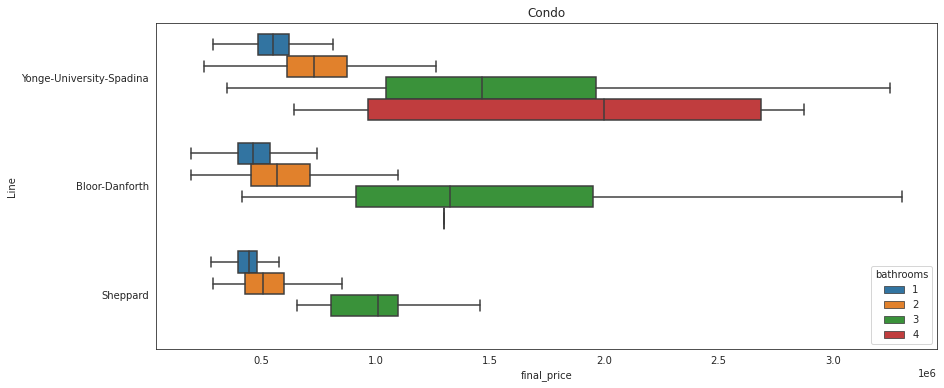

In [43]:
median = []
tar_type = ["Condo Apt"]
kpi = "final_price"
house_dataf = house_data[house_data.type.isin(tar_type)]
fig, ax = plt.subplots(figsize = [14,6])
bx = sns.boxplot(y = "Line", x=kpi, data = house_dataf, hue = "bathrooms", showfliers = False)
bx.set(title="Condo")
plt.show()

In [5]:
house_df = house_data
house_df.drop(["full_link", "full_address", "mls", "description", "district_code", "lat", "long"], axis=1, inplace=True)
#house_df = pd.get_dummies(house_df)
#predictors = house_data_d.drop(["final_price"], axis = 1).columns
#print(predictors)

In [46]:
need_columns = ["final_price","bedrooms", "bathrooms", "parking", "sqft", "type", "Line", "Dist", "mean_district_income"] #temporaily only these two 
houses_dummies = pd.get_dummies(house_df[need_columns])
houses_dummies.head(3)

,final_price,bedrooms,bathrooms,parking,sqft,Dist,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina
0,855000,3,2,1,849.5,0.224219,56526,0,1,0,0,0,0,0,0,0,1
1,550000,1,1,0,549.5,0.407749,57039,0,1,0,0,0,0,0,0,0,1
2,665000,2,1,1,649.5,2.597742,70623,0,1,0,0,0,0,0,0,0,1


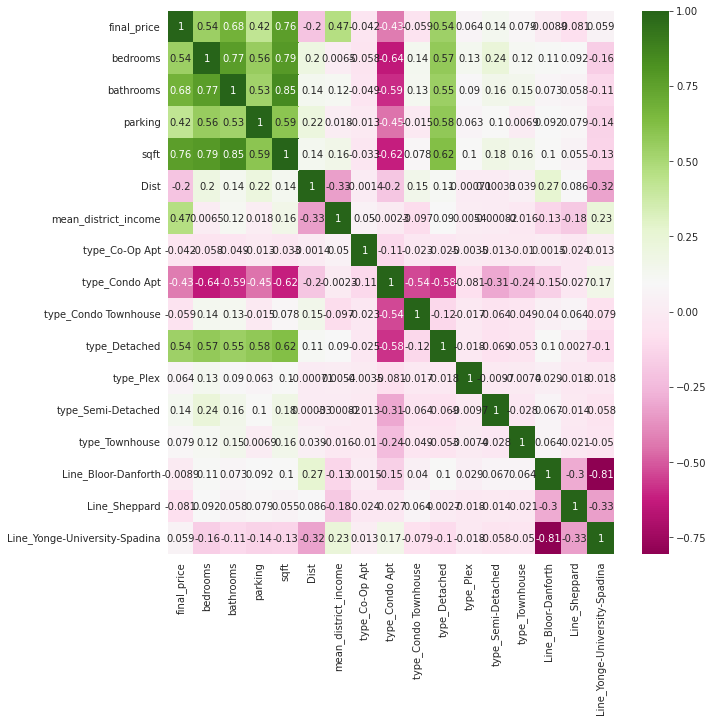

In [47]:
fig, ax = plt.subplots(figsize=[10, 10])
ax = sns.heatmap(houses_dummies.corr(), annot=True,cmap="PiYG")

In [21]:
#need_columns = ["final_price","bedrooms", "bathrooms", "parking", "sqft", "type", "Line", "mean_district_income", "city_district"] #temporaily only these two 
#houses_dummies = pd.get_dummies(house_df[need_columns])


,final_price,bedrooms,bathrooms,parking,sqft,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina,city_district_Agincourt North,city_district_Agincourt South-Malvern West,city_district_Alderwood,city_district_Annex,city_district_Banbury-Don Mills,city_district_Bathurst Manor,city_district_Bay Street Corridor,city_district_Bayview Village,city_district_Bayview Woods-Steeles,city_district_Bedford Park-Nortown,city_district_Beechborough-Greenbrook,city_district_Bendale,city_district_Birchcliffe-Cliffside,city_district_Black Creek,city_district_Blake-Jones,city_district_Briar Hill-Belgravia,city_district_Bridle Path-Sunnybrook-York Mills,city_district_Broadview North,city_district_Brookhaven-Amesbury,city_district_Cabbagetown-South St. James Town,city_district_Caledonia-Fairbank,city_district_Casa Loma,city_district_Centennial Scarborough,city_district_Church-Yonge Corridor,...,city_district_Regent Park,city_district_Rexdale-Kipling,city_district_Rockcliffe-Smythe,city_district_Roncesvalles,city_district_Rosedale-Moore Park,city_district_Rouge,city_district_Runnymede-Bloor West Village,city_district_Rustic,city_district_Scarborough Village,city_district_South Parkdale,city_district_South Riverdale,city_district_St.Andrew-Windfields,city_district_Steeles,city_district_Stonegate-Queensway,city_district_Tam O'Shanter-Sullivan,city_district_Taylor-Massey,city_district_The Beaches,city_district_Thistletown-Beaumond Heights,city_district_Thorncliffe Park,city_district_Trinity-Bellwoods,city_district_University,city_district_Victoria Village,city_district_Waterfront Communities-The Island,city_district_West Hill,city_district_West Humber-Clairville,city_district_Westminster-Branson,city_district_Weston,city_district_Weston-Pelham Park,city_district_Wexford/Maryvale,city_district_Willowdale East,city_district_Willowdale West,city_district_Willowridge-Martingrove-Richview,city_district_Woburn,city_district_Woodbine Corridor,city_district_Woodbine-Lumsden,city_district_Wychwood,city_district_Yonge-Eglinton,city_district_Yonge-St.Clair,city_district_York University Heights,city_district_Yorkdale-Glen Park
0,855000,3,2,1,849.5,56526,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,550000,1,1,0,549.5,57039,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,665000,2,1,1,649.5,70623,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
predictors = houses_dummies.drop('final_price', axis=1).columns
houses_dummies.head(3)

,final_price,bedrooms,bathrooms,parking,sqft,Dist,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina
0,855000,3,2,1,849.5,0.224219,56526,0,1,0,0,0,0,0,0,0,1
1,550000,1,1,0,549.5,0.407749,57039,0,1,0,0,0,0,0,0,0,1
2,665000,2,1,1,649.5,2.597742,70623,0,1,0,0,0,0,0,0,0,1


In [63]:
from sklearn.ensemble import ExtraTreesRegressor

sns.set_style("white")
plt.figure
model = ExtraTreesRegressor(n_estimators = 10)
model.fit(houses_dummies[predictors], houses_dummies.final_price)

ExtraTreesRegressor(n_estimators=10)

['type_Co-Op Apt', 'type_Plex', 'Line_Sheppard', 'type_Townhouse', 'type_Condo Townhouse', 'Line_Bloor-Danforth', 'type_Semi-Detached', 'type_Condo Apt', 'Line_Yonge-University-Spadina', 'parking', 'bedrooms', 'bathrooms', 'Dist', 'type_Detached', 'mean_district_income', 'sqft']


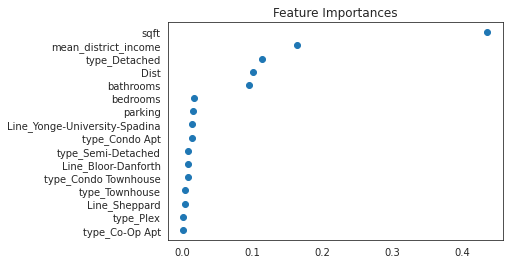

In [64]:
m = zip(model.feature_importances_, houses_dummies[predictors].columns)
sorted_feature_importance = sorted(m)

x = [a[0] for a in sorted_feature_importance]
y = [a[1] for a in sorted_feature_importance]

print(y)
plt.scatter(x,y)
plt.title('Feature Importances')
plt.show()

In [90]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
numeric_feats = ['sqft', 'mean_district_income', 'final_price']
houses = houses_dummies.copy()
predictors = houses.drop(["final_price"], axis=1).columns

yeo_johnson_lambdas = [] 
houses["final_price"] = houses["final_price"] /100
houses["mean_district_income"] = houses["mean_district_income"] /10
for numeric_feat in numeric_feats:
    houses[numeric_feat] = pt.fit_transform(houses[[numeric_feat]])
    yeo_johnson_lambdas.append(pt.lambdas_[0])

In [91]:
from sklearn.metrics import make_scorer, mean_absolute_error
def mae_transform(y, y_pred, **kwargs):
    y_pred[y_pred > 5] = 5
    y = pt.inverse_transform(pd.DataFrame(y)) * 100
    y_pred = pt.inverse_transform(pd.DataFrame(y_pred))  * 100
    return mean_absolute_error(y, y_pred)

custom_mae = make_scorer(mae_transform, greater_is_better=False)

In [92]:
houses.head(3)

,final_price,bedrooms,bathrooms,parking,sqft,Dist,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina
0,0.646832,3,2,1,-0.217721,0.224219,0.381280,0,1,0,0,0,0,0,0,0,1
1,-0.317657,1,1,0,-1.055213,0.407749,0.402931,0,1,0,0,0,0,0,0,0,1
2,0.125399,2,1,1,-0.730228,2.597742,0.876545,0,1,0,0,0,0,0,0,0,1


In [93]:
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
alg = xgb.XGBRegressor(objective='reg:squarederror')
cv_split = KFold(n_splits = 4, shuffle=True, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(houses[predictors], houses["final_price"], test_size=0.33, random_state=42)
cv_scores = cross_validate(alg, X_train, y_train, cv = cv_split, return_train_score=True, scoring = custom_mae)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not h

In [95]:
print("train score", -1*cv_scores["train_score"].mean())
print("test score", -1*cv_scores["test_score"].mean())

train score 100293.49779592328
test score 106007.17452114112


In [103]:
houses.to_csv("houses_model_xgb.csv")

In [110]:
houses_dummies.head(3)

,final_price,bedrooms,bathrooms,parking,sqft,Dist,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina
0,855000,3,2,1,849.5,0.224219,56526,0,1,0,0,0,0,0,0,0,1
1,550000,1,1,0,549.5,0.407749,57039,0,1,0,0,0,0,0,0,0,1
2,665000,2,1,1,649.5,2.597742,70623,0,1,0,0,0,0,0,0,0,1


Hyperparameter Tuning

In [ ]:
! pip install optuna

In [131]:
import optuna
def objective(trial):
  houses = pd.read_csv("houses_model_xgb.csv")
  predictors = houses.drop(["final_price"], axis=1).columns
  train_x, test_x, train_y, test_y = train_test_split(houses[predictors], houses["final_price"], test_size=0.33, random_state=33)
  dtrain = xgb.DMatrix(train_x, label=train_y)
  dtest = xgb.DMatrix(test_x, label=test_y)

  param = {
      "verbosity": 3,  
      "objective": custom_mae,#"reg:squarederror",
      "n_estimators": 1000,
      "n_splits": 4,
      "max_depth": trial.suggest_int("max_depth", 4, 12),
      "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
      "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
      "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
      "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
      "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
      "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
      "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
  }
  # Add a callback for pruning.
  #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
  bst = xgb.train(param, dtrain, evals=[(dtest, "validation")])
  preds = bst.predict(dtest)
  pred_labels = np.rint(preds)
  accuracy = custom_mae
  return accuracy

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2022-02-17 05:16:14,466] A new study created in memory with name: no-name-cabd761f-744e-41fb-a2d6-e8f15f986d4c
[W 2022-02-17 05:16:14,546] Trial 0 failed because of the following error: XGBoostError('[05:16:14] /workspace/src/objective/objective.cc:23: Unknown objective function make_scorer(mae_transform, greater_is_better=False)\nStack trace:\n  [bt] (0) /usr/local/lib/python3.7/dist-packages/xgboost/./lib/libxgboost.so(xgboost::ObjFunction::Create(std::string const&)+0x6d0) [0x7eff27ae6070]\n  [bt] (1) /usr/local/lib/python3.7/dist-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::LazyInitModel()+0x3c1) [0x7eff27a8bff1]\n  [bt] (2) /usr/local/lib/python3.7/dist-packages/xgboost/./lib/libxgboost.so(XGBoosterUpdateOneIter+0x52) [0x7eff279f3ac2]\n  [bt] (3) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7eff64f63dae]\n  [bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7eff64f6371f]\n  [bt] (5) /usr/lib/python3.7/lib-dynload/_ctypes.cpython-37

[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: rank:pairwise
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: rank:ndcg
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: rank:map
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: binary:hinge
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: multi:softmax
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: multi:softprob
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: reg:squarederror
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: reg:logistic
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: binary:logistic
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Objective candidate: binary:logitraw
[05:16:14] INFO: /workspace/src/objective/objective.cc:21: Obje

XGBoostError: ignored